### Modeling - Vector Autoregressive (VAR) model
Company: Bharat Petroleum Corporation Ltd.,ENERGY,BPCL,EQ,INE029A01011 The VWAP (Volume Weighted Average Price) 
is the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the 
stock has traded at throughout the day, based on both volume and price. 
References: 1. https://towardsdatascience.com/multivariate-time-series-forecasting-456ace675971
2. https://www.machinelearningplus.com/vector-autoregression-examples-python/

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

df = pd.read_csv('stock_market.csv')
df.drop(['Time.1'], axis = 1, inplace=True)
df.drop(['Deliverable Volume'], axis = 1, inplace=True)
df.set_index('Time', inplace=True, drop=True)

In [2]:
df.head(2)

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Time,,,,,,,,,
2000-01-03,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11
2000-01-04,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11


In [2]:
data1 = df[['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover']]
data1.head(2)

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Time,,,,,,,,,
2000-01-03,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11
2000-01-04,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11


<AxesSubplot:xlabel='Time'>

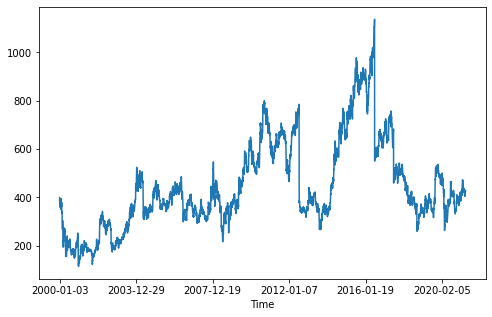

In [3]:
data1['VWAP'].plot(figsize = (8,5))

The series shows an increasing trend over time with slight ups and downs. Stationary: Before applying a VAR model to the data, the time series features should be stationary. The series are not stationary since both the series do not show constant mean and variance over time.

In [5]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['VWAP'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.9260780420523194
p-value: 0.042398433754513964


In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['Prev Close'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.9565223332373485
p-value: 0.03915901585104901


### Stationary Time Series: Augmented Dickey-Fuller test (ADF)
A smaller p-value should try to be achieved. So, perform differencing to get a smaller p-value.
First, the data is standardized with MinMaxScaler.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data1)
data = pd.DataFrame(dataset, index = data1.index, columns=data1.columns)

In [5]:
data_diff = data.diff().dropna()

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data_diff['VWAP'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -51.24286133664201
p-value: 0.0


In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data_diff['Prev Close'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -72.940478744401
p-value: 0.0


## Modeling for VAR

We carry-out the train-test split of the data and keep the last 10-days as test data.

In [8]:
train = data[['VWAP', 'Prev Close']].iloc[:-10,:]
test = data[['VWAP', 'Prev Close']].iloc[-10:,:]

df_diff_train = data_diff[['VWAP', 'Prev Close']].iloc[:-10,:]
df_diff_test = data_diff[['VWAP', 'Prev Close']].iloc[-10:,:]

#### Searching optimal order of VAR model
Hypertuning the order of the model VAR

In [9]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10): # order of the model
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

# Using the differenced data:
forecasting_model_diff = VAR(df_diff_train)
results_aic_diff = []
for p in range(1,10): # order of the model
  results_diff = forecasting_model_diff.fit(p)
  results_aic_diff.append(results_diff.aic)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


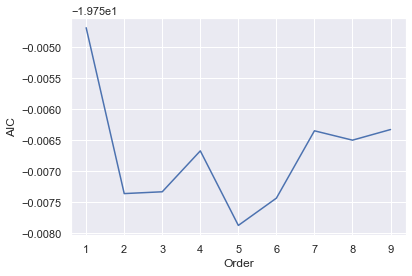

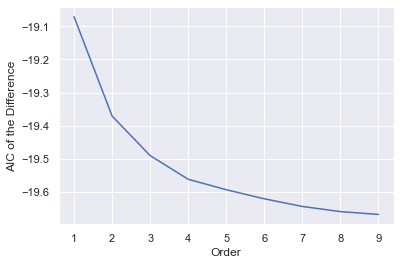

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic_diff)
plt.xlabel("Order")
plt.ylabel("AIC of the Difference")
plt.show()

In [11]:
results = forecasting_model.fit(5)
results.summary()

results_diff = forecasting_model_diff.fit(4)
results_diff.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Jun, 2021
Time:                     16:29:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.5402
Nobs:                     5291.00    HQIC:                  -19.5548
Log likelihood:           36755.6    FPE:                3.19207e-09
AIC:                     -19.5626    Det(Omega_mle):     3.18123e-09
--------------------------------------------------------------------
Results for equation VWAP
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.000005         0.000190            0.027           0.978
L1.VWAP               0.078906         0.014404            5.478           0.000
L1.Prev Close        -0.106802         0.045011           -2.

### Forecasting

Use 5 as the optimal order in fitting the VAR model. Thus, we take the final 10 steps in the training data for 
forecasting the immediate next step (i.e., the first day of the test data).

In [12]:
lagged_values = train.values[-5:]
forecast_1D = pd.DataFrame(results.forecast(y= lagged_values, steps=10), index = test.index, columns= ['VWAP_1d', 'Prev Close_1d'])
forecast_1D

lagged_values_diff = df_diff_train.values[-4:] # Use order = 4 for diff values
forecast_1D_diff = pd.DataFrame(results_diff.forecast(y= lagged_values_diff, steps=10), index = df_diff_test.index, columns= ['VWAP_1d', 'Prev Close_1d'])
forecast_1D_diff

,VWAP_1d,Prev Close_1d
Time,,
2021-04-16,-2.884165e-04,-0.004990
2021-04-19,3.154114e-04,0.000400
2021-04-20,-8.277668e-05,0.000467
2021-04-22,1.395389e-04,0.000010
2021-04-23,-1.772660e-05,-0.000046
2021-04-26,-1.455437e-05,0.000012
2021-04-27,2.447981e-06,0.000020
2021-04-28,1.889647e-05,0.000010
2021-04-29,-2.817570e-07,-0.000014


The forecasts are for the one differenced model: we must reverse the first differenced forecasts into the original 
forecast values.

#### Forecasted
The first two columns are the forecasted values for 1 differenced series and the last two columns show the 
forecasted values for the original series.

In [13]:
forecast = pd.DataFrame()
forecast["VWAP_forecasted"] = data1["VWAP"].iloc[-10-1] + forecast_1D['VWAP_1d'].cumsum()
forecast["Prev Close_forecasted"] = data1["Prev Close"].iloc[-10-1] + forecast_1D['Prev Close_1d'].cumsum()

forecast_diff = pd.DataFrame()
forecast_diff["VWAP_forecasted"] = df_diff_train["VWAP"].iloc[-10-1] + forecast_1D_diff['VWAP_1d'].cumsum()
forecast_diff["Prev Close_forecasted"] = df_diff_train["Prev Close"].iloc[-10-1] + forecast_1D_diff['Prev Close_1d'].cumsum()

<AxesSubplot:xlabel='Time'>

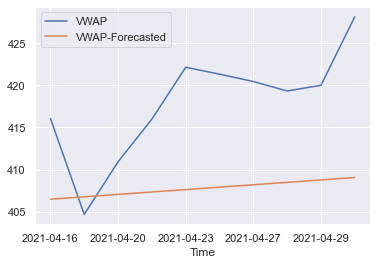

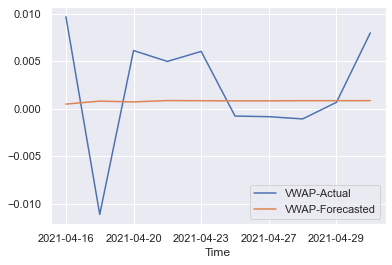

In [14]:
total = pd.DataFrame()
total["VWAP"] = data1["VWAP"]
total["VWAP-Forecasted"] = forecast["VWAP_forecasted"]
total.tail(10).plot()
#total.plot(figsize = (8,5))

total_diff = pd.DataFrame()
total_diff["VWAP-Actual"] = df_diff_test["VWAP"]
total_diff["VWAP-Forecasted"] = forecast_diff["VWAP_forecasted"]
total_diff.tail(10).plot()
#total.plot(figsize = (8,5))

In [15]:
df_diff = data.diff().dropna()

model = VAR(df_diff)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

model_diff = VAR(df_diff_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    result_diff = model_diff.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result_diff.aic)
    print('BIC : ', result_diff.bic)
    print('FPE : ', result_diff.fpe)
    print('HQIC: ', result_diff.hqic, '\n')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Lag Order = 1
AIC :  -158.70215897529118
BIC :  -158.5905715907007
FPE :  1.192691456608612e-69
HQIC:  -158.6631660051805 

Lag Order = 2
AIC :  -159.8006444650163
BIC :  -159.58859453401678
FPE :  3.9761432647607783e-70
HQIC:  -159.72654526901945 

Lag Order = 3
AIC :  -159.78019327920305
BIC :  -159.46764866858706
FPE :  4.058299786465109e-70
HQIC:  -159.67097595866855 

Lag Order = 4
AIC :  -159.8115421843455
BIC :  -159.39847074435139
FPE :  3.933054559331516e-70
HQIC:  -159.66719483431268 

Lag Order = 5
AIC :  -160.1407624807636
BIC :  -159.6271320450637
FPE :  2.8297771184030895e-70
HQIC:  -159.9612731899582 

Lag Order = 6
AIC :  -159.27173550545032
BIC :  -158.65751389113933
FPE :  6.747875492986013e-70
HQIC:  -159.05709235627987 

Lag Order = 7
AIC :  -159.54513541948435
BIC :  -158.83029042706772
FPE :  5.1337257767718466e-70
HQIC:  -159.29532648803368 

Lag Order = 8
AIC :  -159.27475998155768
BIC :  -158.4592593949398
FPE :  6.727558064671739e-70
HQIC:  -158.98977333758432

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Lag Order = 10
AIC :  -19.678062468492637
BIC :  -19.6258296640028
FPE :  2.843977077915221e-09
HQIC:  -19.659806982534796 

Lag Order = 11
AIC :  -19.679610700186345
BIC :  -19.622394163732988
FPE :  2.839577423957823e-09
HQIC:  -19.659613196959533 

Lag Order = 12
AIC :  -19.687067760160033
BIC :  -19.6248658919302
FPE :  2.81848136848169e-09
HQIC:  -19.66532764712607 

Lag Order = 13
AIC :  -19.6877002033875
BIC :  -19.6205114027411
FPE :  2.8166995062305728e-09
HQIC:  -19.664216887692895 

Lag Order = 14
AIC :  -19.690079196997267
BIC :  -19.617901862466496
FPE :  2.8100066805017727e-09
HQIC:  -19.664852085473004 

Lag Order = 15
AIC :  -19.694259278729852
BIC :  -19.6170918080186
FPE :  2.798285275758423e-09
HQIC:  -19.66728777789115 

Lag Order = 16
AIC :  -19.69889919535582
BIC :  -19.61673998533908
FPE :  2.785331696331793e-09
HQIC:  -19.67018271140191 

Lag Order = 17
AIC :  -19.7016209040219
BIC :  -19.6144683507452
FPE :  2.777761317299767e-09
HQIC:  -19.671158842835798 

La

In [16]:
x = model.select_order(maxlags=20)
x.summary()

x_diff = model_diff.select_order(maxlags=20)
x_diff.summary()

,AIC,BIC,FPE,HQIC
0,-17.03,-17.03,4.008e-08,-17.03
1,-19.07,-19.06,5.245e-09,-19.06
2,-19.37,-19.35,3.883e-09,-19.36
3,-19.49,-19.47,3.444e-09,-19.48
4,-19.56,-19.54,3.205e-09,-19.55
5,-19.59,-19.56,3.105e-09,-19.58
6,-19.62,-19.59,3.020e-09,-19.61
7,-19.64,-19.60,2.950e-09,-19.63
8,-19.66,-19.62,2.903e-09,-19.64
9,-19.67,-19.62,2.878e-09,-19.65


The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

### Observe that lag = 5 is the optimal order.

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12 #lag_order 
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)
print(o)

o = grangers_causation_matrix(df_diff_train, variables = df_diff_train.columns)

              VWAP_x  Prev Close_x
VWAP_y           1.0           0.0
Prev Close_y     0.0           1.0


From Scholarpedia: Granger causality is a statistical concept of causality that is based on prediction. According to Granger causality, if a signal X1 "Granger-causes" (or "G-causes") a signal X2, then past values of X1 should contain information that helps predict X2 above and beyond the information contained in past values of X2 alone.

The p-value between VWAP and Prev_Close is 0. Thus, it is not true that VWAP does not depend on Prev_Close and it is not true that Prev_Close does not depend on VWAP.

In [20]:
from statsmodels.tsa.stattools import acf
import numpy as np

In [22]:
# actual = total_diff["VWAP-Actual"]
# forecast = total_diff["VWAP-Forecasted"]

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

# print('Forecast Accuracy of: rgnp')
# accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])

print('Forecast Accuracy of: VWAP-Actual')
accuracy_prod = forecast_accuracy(total_diff["VWAP-Forecasted"].values, total_diff["VWAP-Actual"])

for k, v in accuracy_prod.items():
    # print(adjust(k), ': ', round(v,4))
    print(k, ': ', round(v,4))

Forecast Accuracy of: VWAP-Actual
mape :  1.1466
me :  -0.0014
mae :  0.0048
mpe :  -1.0946
rmse :  0.006
corr :  -0.3931
minmax :  2.6305


<ipython-input-22-0c3a2c70e4a8>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-22-0c3a2c70e4a8>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
